# Evaluate trained policies at checkpoints

In [1]:
from gymnasium.experimental.wrappers import RecordVideoV0
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

import _pickle as pickle
import jax
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import timeit

from jaxl.buffers import get_buffer
from jaxl.constants import *
from jaxl.models import (
    get_model,
    get_policy,
    policy_output_dim,
)
from jaxl.models.policies import MultitaskPolicy
from jaxl.envs import get_environment
from jaxl.envs.rollouts import EvaluationRollout
from jaxl.utils import (
    set_seed,
    parse_dict,
    set_dict_value,
    get_dict_value,
    RunningMeanStd,
)

In [2]:
run_seed = None
set_seed(run_seed)

In [3]:
def get_env(agent_path):
    agent_config_path = os.path.join(agent_path, "config.json")
    with open(agent_config_path, "r") as f:
        agent_config_dict = json.load(f)
    return agent_config_dict["learner_config"]["env_config"]

In [4]:
agent_path = "/Users/chanb/research/personal/mtil_results/data_from_pretrain/experts/cheetah/discrete/runs/0/variant-93/07-27-23_04_24_54-3d3edfc9-2dc4-4d7d-b813-aa543828e429"
trained_env_parameters = get_env(agent_path)

agent_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/cheetah_discrete/bc-1000/07-27-23_14_09_37-ecacb78c-3795-4195-92e9-ce0b74071982"
policy_type = CONST_SOFTMAX

num_episodes = 10
env_seed = 10
buffer_size = 0
record_video = True

In [5]:
def get_config(agent_path):
    agent_config_path = os.path.join(agent_path, "config.json")
    with open(agent_config_path, "r") as f:
        agent_config_dict = json.load(f)
        agent_config_dict["learner_config"]["env_config"] = trained_env_parameters
        agent_config_dict["learner_config"]["env_config"]["env_kwargs"][
            "render_mode"
        ] = "rgb_array"
        if "policy_distribution" not in agent_config_dict["learner_config"]:
            agent_config_dict["learner_config"]["policy_distribution"] = policy_type
        set_dict_value(agent_config_dict, "vmap_all", False)
        (multitask, num_models) = get_dict_value(agent_config_dict, "num_models")
        agent_config = parse_dict(agent_config_dict)
    return agent_config, {
        "multitask": multitask,
        "num_models": num_models,
    }

In [6]:
# Build agent and policy
agent_config, aux = get_config(agent_path)
env = get_environment(agent_config.learner_config.env_config)

input_dim = env.observation_space.shape
output_dim = policy_output_dim(env.act_dim, agent_config.learner_config)
model = get_model(
    input_dim,
    output_dim,
    getattr(agent_config.model_config, "policy", agent_config.model_config),
)
policy = get_policy(model, agent_config.learner_config)
if aux["multitask"]:
    policy = MultitaskPolicy(policy, model, aux["num_models"])
env.close()

/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
episodic_returns_per_variant = {}
checkpoint_manager = CheckpointManager(
    os.path.join(agent_path, "models"),
    PyTreeCheckpointer(),
)
for checkpoint_step in checkpoint_manager.all_steps():
    env = get_environment(agent_config.learner_config.env_config)
    if record_video:
        env = RecordVideoV0(
            env,
            f"videos/eval_checkpoints/model_id_{checkpoint_step}-videos",
            disable_logger=True,  # , episode_trigger=lambda x: True
        )
    params = checkpoint_manager.restore(checkpoint_step)
    model_dict = params[CONST_MODEL_DICT]
    agent_policy_params = model_dict[CONST_MODEL][CONST_POLICY]
    agent_obs_rms = False
    if CONST_OBS_RMS in params:
        agent_obs_rms = RunningMeanStd()
        agent_obs_rms.set_state(params[CONST_OBS_RMS])

    agent_rollout = EvaluationRollout(env, seed=env_seed)
    agent_rollout.rollout(
        agent_policy_params, policy, agent_obs_rms, num_episodes, None
    )

    episodic_returns_per_variant[checkpoint_step] = agent_rollout.episodic_returns
    env.close()

/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/gymnasium/experimental/wrappers/rendering.py:169: UserWarning: WARN: Overwriting existing videos at /Users/chanb/research/personal/jaxl/notebooks/videos/eval_checkpoints/model_id_1-videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 10/10 [00:25<00:00,  2.54s/it]
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
100%|██████████| 10/10 [00:25<00:00,  2.56s/it]
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
100%|██████████| 10/10 [00:25<00:00, 

In [8]:
if hasattr(env, "get_config"):
    print(env.get_config())

{'xml': '<mujoco model="cheetah">\n  <include file="./common/skybox.xml" />\n  <include file="./common/visual.xml" />\n  <include file="./common/materials.xml" />\n\n  <compiler settotalmass="14" />\n\n  <default>\n    <default class="cheetah">\n      <joint limited="true" damping=".01" armature=".1" stiffness="8" type="hinge" axis="0 1 0" />\n      <geom contype="1" conaffinity="1" condim="3" friction=".4 .1 .1" material="self" />\n    </default>\n    <default class="free">\n      <joint limited="false" damping="0" armature="0" stiffness="0" />\n    </default>\n    <motor ctrllimited="true" ctrlrange="-1 1" />\n  </default>\n\n  <statistic center="0 0 .7" extent="2" />\n\n  <option timestep="0.01" />\n\n  <worldbody>\n    <geom name="ground" type="plane" conaffinity="1" pos="98 0 0" size="100 .8 .5" material="grid" />\n    <body name="torso" pos="0 0 .7" childclass="cheetah">\n      <light name="light" pos="0 0 2" mode="trackcom" />\n      <camera name="side" pos="0 -3 0" quat="0.707 

In [9]:
from pprint import pprint

pprint(
    [
        (key, np.mean(val), np.std(val))
        for key, val in episodic_returns_per_variant.items()
    ]
)

[(1, 57.18623274800366, 21.59571214777245),
 (1000, 85.34859945930961, 28.539797889296317),
 (2000, 31.07812883744823, 17.635771671760818)]


/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_84575/3652737342.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


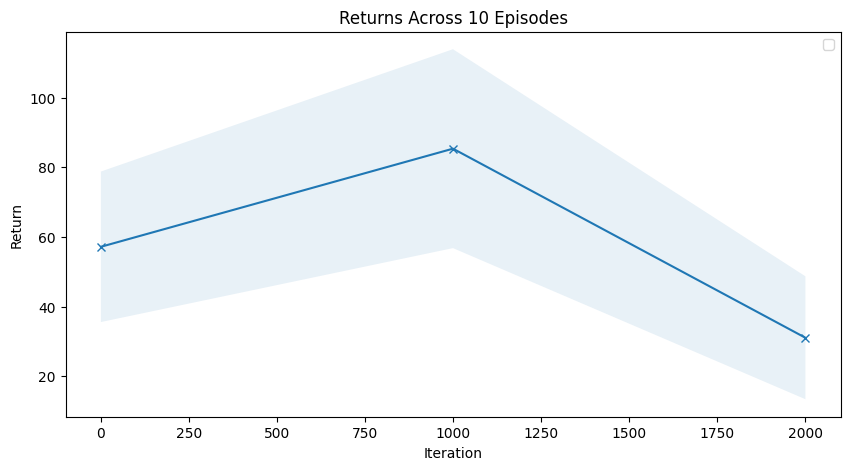

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 5))

model_ids = list(episodic_returns_per_variant.keys())
means = []
stds = []
for val in episodic_returns_per_variant.values():
    means.append(np.mean(val))
    stds.append(np.std(val))
means = np.array(means)
stds = np.array(stds)

sort_idxes = np.argsort(model_ids)
model_ids = np.array(model_ids)
ax.plot(model_ids[sort_idxes], means[sort_idxes], marker="x")
ax.fill_between(
    model_ids[sort_idxes],
    means[sort_idxes] + stds[sort_idxes],
    means[sort_idxes] - stds[sort_idxes],
    alpha=0.1,
)
ax.set_title(f"Returns Across {num_episodes} Episodes")
ax.set_xlabel("Iteration")
ax.set_ylabel("Return")
ax.legend()
fig.show()